In [1]:
import IPython
import simpy
import matplotlib.pyplot as plt
import concurrent
import prettymaps as pm
import myutils

In [2]:
G = myutils.load_map()

In [3]:
class StationModel():
    stations = set()
    def __init__(self, routeId, varId) -> None:
        src = myutils.STOPS_FILE + str(varId)
        api = myutils.STOPS_API(id=routeId, varId=varId)
        stops_df = myutils.load_data(route=routeId, source=src, api=api)
        self.stops_df = stops_df[["StopId", "Lat", "Lng"]]
        self.stops_df = self.stops_df.rename(columns={"StopId":"stop_id", "Lat":"lat", "Lng":"lng"})

        StationModel.stations.update(self.stops_df["stop_id"].tolist())

In [6]:
class BusModel():
    def __init__(self, id) -> None:
        self.route = id
        self.stations = dict()
        self.paths_df = dict()
        timetables_df = myutils.load_data(route=id, source=myutils.TIMETABLE_FILE, api=myutils.TIMETABLE_API(id))
        for varId in timetables_df["RouteVarId"]:
            self.stations[varId] = StationModel(routeId=id, varId=varId)
            src = myutils.PATHS_FILE + str(varId)
            self.paths_df[varId] = myutils.load_data(route=id, source=src, api=myutils.PATHS_API(id, varId=varId))
        
    def prepare_path(self):
        is_used_local = False

        for varId in self.paths_df.keys():
            source = myutils.DF_FILE + str(varId)
            try:
                self.paths_df[varId] = myutils.load_path_data(route=self.route, source=source)
                is_used_local = True
            except FileNotFoundError:
                break

        if is_used_local: return

        with concurrent.futures.ProcessPoolExecutor() as executor:
            params = [(varId, self.paths_df[varId], self.stations[varId].stops_df, G) for varId in self.paths_df.keys()]
            results = executor.map(myutils.get_routes_from_paths, params)
            for result in results:
                id, df = result
                self.paths_df[id] = df
                myutils.save_path_data(route=self.route, var=id, df=df)

In [7]:
buses = list()
bus_ids = [8, 51, 30]
for id in bus_ids:
    bus = BusModel(id)
    buses.append(bus)
    bus.prepare_path()

In [97]:
x = buses[0].paths_df[15].apply(lambda path: G.nodes[path["edge"][0]]["x"], axis="columns")
y = buses[0].paths_df[15].apply(lambda path: G.nodes[path["edge"][0]]["y"], axis="columns")
north = y.max()
south = y.min()
east = x.max()
west = x.min()
padding = 0.04
padding_ns = (north - south) * padding
padding_ew = (east - west) * padding
bbox = north + padding_ns, south - padding_ns, east + padding_ew, west - padding_ew
trunc_G = myutils.ox.truncate.truncate_graph_bbox(G, *bbox)

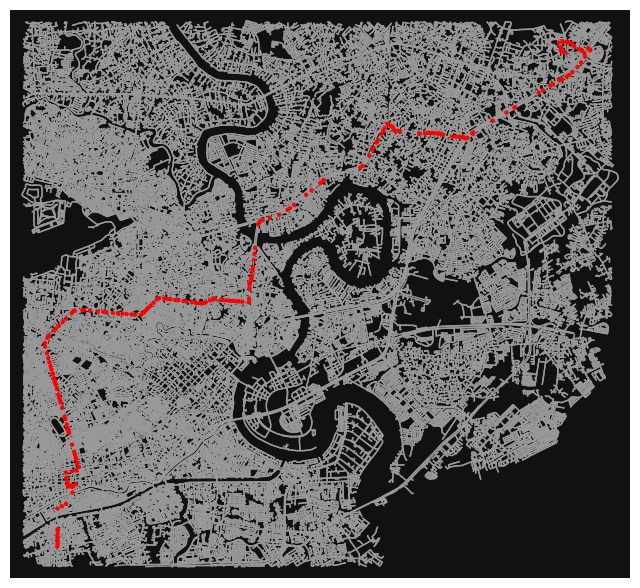

In [101]:
fig, ax = myutils.ox.plot_graph(trunc_G, node_size=0, edge_linewidth=1, show=False)
ax.scatter(x, y, s=10, c="r", alpha=1, edgecolor="none")

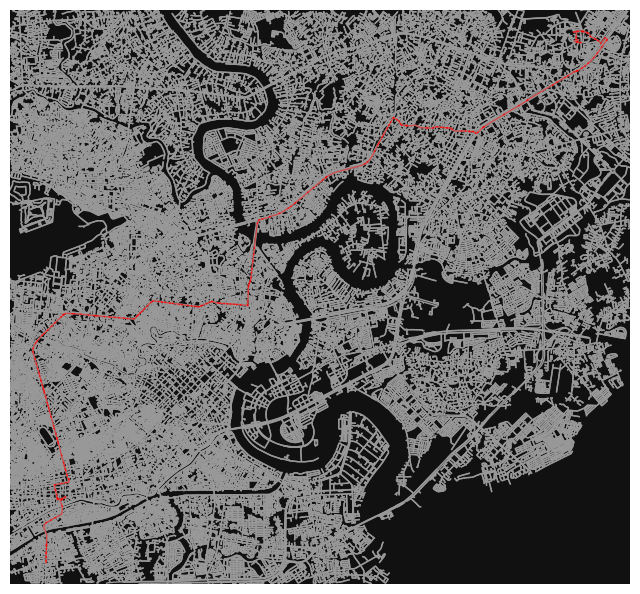

In [96]:
routes = buses[0].paths_df[15]["route"]
map_fig, map_axes = myutils.ox.plot_graph_routes(trunc_G, routes, route_linewidths=1, bbox=bbox, orig_dest_size=1, node_size=0, edge_linewidth=1)